# 1.6. Nearest Neighbors
  
**`sklearn.neighbors` provides functionality for unsupervised and supervised neighbors-based learning methods.** Unsupervised nearest neighbors is the foundation of many other learning methods, notably manifold learning and spectral clustering. **Supervised neighbors-based learning comes in two flavors: classification for data with discrete labels, and regression for data with continuous labels.**  
  
**The principle behind nearest neighbor methods is to find a predefined number of training samples closest in distance to the new point, and predict the label from these.** The number of samples can be a user-defined constant (k-nearest neighbor learning), or vary based on the local density of points (radius-based neighbor learning). The distance can, in general, be any metric measure: standard Euclidean distance is the most common choice. **Neighbors-based methods are known as non-generalizing machine learning methods**, since they simply “remember” all of its training data (possibly transformed into a fast indexing structure such as a Ball Tree or KD Tree.).  
  
**Despite its simplicity, nearest neighbors has been successful in a large number of classification and regression problems**, including handwritten digits or satellite image scenes. Being a non-parametric method, it is often successful in classification situations where the decision boundary is very irregular.  
  
**The classes in sklearn.neighbors can handle either Numpy arrays or scipy.sparse matrices as input.** For dense matrices, a large number of possible distance metrics are supported. For sparse matrices, arbitrary Minkowski metrics are supported for searches.  
  
There are many learning routines which rely on nearest neighbors at their core. One example is **kernel density estimation**, discussed in the density estimation section.  

## 1.6.1. Unsupervised Nearest Neighbors

`NearestNeighbors` implements unsupervised nearest neighbors learning. It acts as a uniform interface to three different nearest neighbors algorithms: `BallTree`, `KDTree`, and a `brute-force algorithm` based on routines in sklearn.metrics.pairwise. The choice of neighbors search algorithm is controlled through the keyword 'algorithm', which must be one of `['auto', 'ball_tree', 'kd_tree', 'brute']`. **When the default value 'auto' is passed, the algorithm attempts to determine the best approach from the training data.** For a discussion of the strengths and weaknesses of each option, see Nearest Neighbor Algorithms below.  
  
#### Warning
  
**Regarding the Nearest Neighbors algorithms, if two neighbors, neighbor $k+1$ and $k$, have identical distances but different labels, the results will depend on the ordering of the training data.**

### 1.6.1.1. Finding the Nearest Neighbors
  
For the simple task of finding the nearest neighbors between two sets of data, the unsupervised algorithms within `sklearn.neighbors` can be used:

In [1]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)
indices

array([[0, 1],
       [1, 0],
       [2, 1],
       [3, 4],
       [4, 3],
       [5, 4]])

In [2]:
distances

array([[0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.41421356],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.41421356]])

It is also possible to efficiently produce a sparse graph showing the connections between neighboring points:

In [3]:
nbrs.kneighbors_graph(X).toarray()

array([[1., 1., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0.],
       [0., 1., 1., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0.],
       [0., 0., 0., 1., 1., 0.],
       [0., 0., 0., 0., 1., 1.]])

Such a sparse graph is useful in a variety of circumstances which make use of spatial relationships between points for unsupervised learning: in particular, see [sklearn.manifold.Isomap](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html#sklearn.manifold.Isomap), [sklearn.manifold.LocallyLinearEmbedding](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.LocallyLinearEmbedding.html#sklearn.manifold.LocallyLinearEmbedding), and [sklearn.cluster.SpectralClustering](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html#sklearn.cluster.SpectralClustering).

### 1.6.1.2. KDTree and BallTree Classes
  
Alternatively, one can use the `KDTree` or `BallTree` classes directly to find nearest neighbors. This is the functionality wrapped by the `NearestNeighbors` class used above. The Ball Tree and KD Tree have the same interface; we’ll show an example of using the `KD Tree` here:  

In [4]:
from sklearn.neighbors import KDTree
import numpy as np
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
kdt = KDTree(X, leaf_size=30, metric='euclidean')
kdt.query(X, k=2, return_distance=False)  

array([[0, 1],
       [1, 0],
       [2, 1],
       [3, 4],
       [4, 3],
       [5, 4]])

## 1.6.2. Nearest Neighbors Classification
  
Neighbors-based classification is a type of *instance-based learning* or *non-generalizing learning*: **it does not attempt to construct a general internal model, but simply stores instances of the training data**. **Classification is computed from a simple majority vote of the nearest neighbors of each point**: a query point is assigned the data class which has the most representatives within the nearest neighbors of the point.  
  
Scikit-learn implements two different nearest neighbors classifiers: `KNeighborsClassifier` implements learning based on the $k$ nearest neighbors of each query point, where $k$ is an integer value specified by the user.   `RadiusNeighborsClassifier` implements learning based on the number of neighbors within a fixed radius $r$ of each training point, where $r$ is a floating-point value specified by the user.  
  
**In cases where the data is not uniformly sampled, radius-based neighbors classification in RadiusNeighborsClassifier can be a better choice.** The user specifies a fixed radius r, such that points in sparser neighborhoods use fewer nearest neighbors for the classification. **For high-dimensional parameter spaces, this method becomes less effective due to the so-called *“curse of dimensionality”*.**  
  
**The basic nearest neighbors classification uses uniform weights**: that is, the value assigned to a query point is computed from a simple majority vote of the nearest neighbors. **Under some circumstances, it is better to weight the neighbors such that nearer neighbors contribute more to the fit. This can be accomplished through the `weights` keyword.** The default value, `weights = 'uniform'`, assigns uniform weights to each neighbor. `weights = 'distance'` assigns weights proportional to the inverse of the distance from the query point. Alternatively, a user-defined function of the distance can be supplied which is used to compute the weights.  

### Sample usage of Nearest Neighbors classification. It will plot the decision boundaries for each class.

Automatically created module for IPython interactive environment


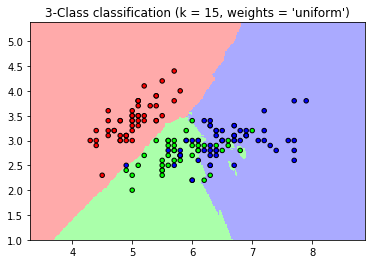

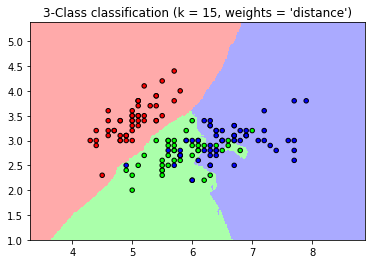

In [5]:
%matplotlib inline
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

n_neighbors = 15

# import some data to play with
iris = datasets.load_iris()

# we only take the first two features. We could avoid this ugly
# slicing by using a two-dim dataset
X = iris.data[:, :2]
y = iris.target

h = .02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

for weights in ['uniform', 'distance']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
                edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("3-Class classification (k = %i, weights = '%s')"
              % (n_neighbors, weights))

plt.show()

## 1.6.3. Nearest Neighbors Regression
  
**Neighbors-based regression can be used in cases where the data labels are continuous rather than discrete variables. The label assigned to a query point is computed based on the mean of the labels of its nearest neighbors.**  
  
scikit-learn implements two different neighbors regressors: `KNeighborsRegressor` implements learning based on the $k$ nearest neighbors of each query point, where $k$ is an integer value specified by the user. `RadiusNeighborsRegressor` implements learning based on the neighbors within a fixed radius $r$ of the query point, where $r$ is a floating-point value specified by the user.  
  
**The basic nearest neighbors regression uses uniform weights**: that is, each point in the local neighborhood contributes uniformly to the classification of a query point. **Under some circumstances, it can be advantageous to weight points such that nearby points contribute more to the regression than faraway points. This can be accomplished through the `weights` keyword**. The default value, `weights = 'uniform'`, assigns equal weights to all points. `weights = 'distance'` assigns weights proportional to the inverse of the distance from the query point. Alternatively, a user-defined function of the distance can be supplied, which will be used to compute the weights.

### Nearest Neighbors regression expample

Demonstrate the resolution of a regression problem using a k-Nearest Neighbor and the interpolation of the target using both barycenter and constant weights.

Automatically created module for IPython interactive environment


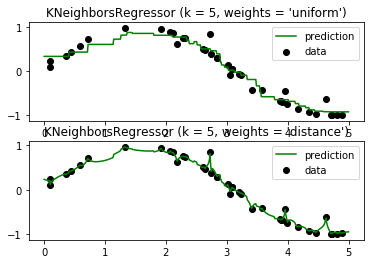

In [6]:
%matplotlib inline
print(__doc__)

# Author: Alexandre Gramfort <alexandre.gramfort@inria.fr>
#         Fabian Pedregosa <fabian.pedregosa@inria.fr>
#
# License: BSD 3 clause (C) INRIA


# #############################################################################
# Generate sample data
import numpy as np
import matplotlib.pyplot as plt
from sklearn import neighbors

np.random.seed(0)
X = np.sort(5 * np.random.rand(40, 1), axis=0)
T = np.linspace(0, 5, 500)[:, np.newaxis]
y = np.sin(X).ravel()

# Add noise to targets
y[::5] += 1 * (0.5 - np.random.rand(8))

# #############################################################################
# Fit regression model
n_neighbors = 5

for i, weights in enumerate(['uniform', 'distance']):
    knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
    y_ = knn.fit(X, y).predict(T)

    plt.subplot(2, 1, i + 1)
    plt.scatter(X, y, c='k', label='data')
    plt.plot(T, y_, c='g', label='prediction')
    plt.axis('tight')
    plt.legend()
    plt.title("KNeighborsRegressor (k = %i, weights = '%s')" % (n_neighbors,
                                                                weights))

plt.show()

### Face completion with a multi-output estimators
  
This example shows the use of multi-output estimator to complete images. The goal is to predict the lower half of a face given its upper half.  
  
The first column of images shows true faces. The next columns illustrate how extremely randomized trees, k nearest neighbors, linear regression and ridge regression complete the lower half of those faces.

Automatically created module for IPython interactive environment
downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /home/tk/scikit_learn_data


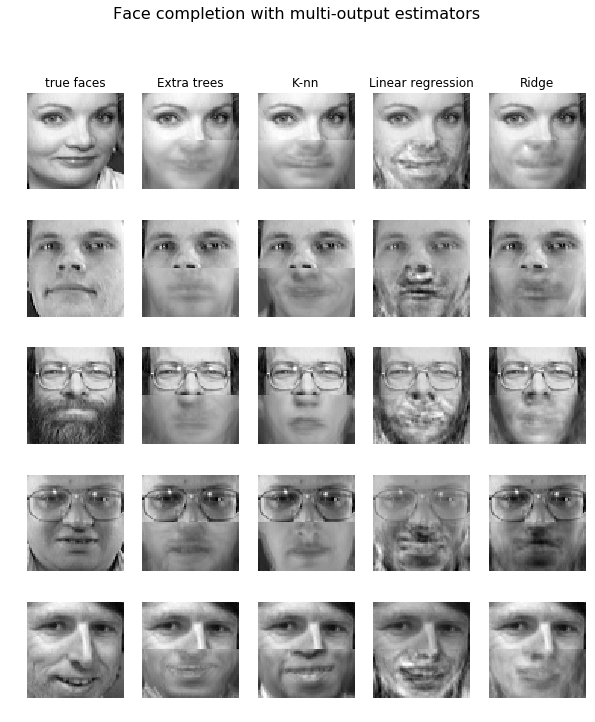

In [7]:
%matplotlib inline
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_olivetti_faces
from sklearn.utils.validation import check_random_state

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

# Load the faces datasets
data = fetch_olivetti_faces()
targets = data.target

data = data.images.reshape((len(data.images), -1))
train = data[targets < 30]
test = data[targets >= 30]  # Test on independent people

# Test on a subset of people
n_faces = 5
rng = check_random_state(4)
face_ids = rng.randint(test.shape[0], size=(n_faces, ))
test = test[face_ids, :]

n_pixels = data.shape[1]
# Upper half of the faces
X_train = train[:, :(n_pixels + 1) // 2]
# Lower half of the faces
y_train = train[:, n_pixels // 2:]
X_test = test[:, :(n_pixels + 1) // 2]
y_test = test[:, n_pixels // 2:]

# Fit estimators
ESTIMATORS = {
    "Extra trees": ExtraTreesRegressor(n_estimators=10, max_features=32,
                                       random_state=0),
    "K-nn": KNeighborsRegressor(),
    "Linear regression": LinearRegression(),
    "Ridge": RidgeCV(),
}

y_test_predict = dict()
for name, estimator in ESTIMATORS.items():
    estimator.fit(X_train, y_train)
    y_test_predict[name] = estimator.predict(X_test)

# Plot the completed faces
image_shape = (64, 64)

n_cols = 1 + len(ESTIMATORS)
plt.figure(figsize=(2. * n_cols, 2.26 * n_faces))
plt.suptitle("Face completion with multi-output estimators", size=16)

for i in range(n_faces):
    true_face = np.hstack((X_test[i], y_test[i]))

    if i:
        sub = plt.subplot(n_faces, n_cols, i * n_cols + 1)
    else:
        sub = plt.subplot(n_faces, n_cols, i * n_cols + 1,
                          title="true faces")

    sub.axis("off")
    sub.imshow(true_face.reshape(image_shape),
               cmap=plt.cm.gray,
               interpolation="nearest")

    for j, est in enumerate(sorted(ESTIMATORS)):
        completed_face = np.hstack((X_test[i], y_test_predict[est][i]))

        if i:
            sub = plt.subplot(n_faces, n_cols, i * n_cols + 2 + j)

        else:
            sub = plt.subplot(n_faces, n_cols, i * n_cols + 2 + j,
                              title=est)

        sub.axis("off")
        sub.imshow(completed_face.reshape(image_shape),
                   cmap=plt.cm.gray,
                   interpolation="nearest")

plt.show()

## 1.6.4. Nearest Neighbor Algorithms

### 1.6.4.1. Brute Force
**Fast computation of nearest neighbors is an active area of research in machine learning. The most naive neighbor search implementation involves the brute-force computation of distances between all pairs of points in the dataset:** for $N$ samples in $D$ dimensions, this approach scales as $O[D N^2]$. **Efficient brute-force neighbors searches can be very competitive for small data samples. However, as the number of samples $N$ grows, the brute-force approach quickly becomes infeasible.** In the classes within `sklearn.neighbors`, brute-force neighbors searches are specified using the keyword `algorithm = 'brute'`, and are computed using the routines available in `sklearn.metrics.pairwise`.  
  
### 1.6.4.2. K-D Tree
  
To address the computational inefficiencies of the brute-force approach, a variety of tree-based data structures have been invented. In general, these structures attempt to reduce the required number of distance calculations by efficiently encoding aggregate distance information for the sample. **The basic idea is that if point $A$ is very distant from point $B$, and point $B$ is very close to point $C$, then we know that points $A$ and $C$ are very distant, without having to explicitly calculate their distance.** In this way, the computational cost of a nearest neighbors search can be reduced to $O[D N \log(N)]$ or better. **This is a significant improvement over brute-force for large $N$.**  
  
An early approach to taking advantage of this aggregate information was the KD tree data structure (short for K-dimensional tree), which generalizes two-dimensional Quad-trees and 3-dimensional Oct-trees to an arbitrary number of dimensions.   
  
**Though the KD tree approach is very fast for low-dimensional (D < 20) neighbors searches, it becomes inefficient as D grows very large: this is one manifestation of the so-called “curse of dimensionality”.** In scikit-learn, KD tree neighbors searches are specified using the keyword `algorithm = 'kd_tree'`, and are computed using the class KDTree.  
  
References:  
- [“Multidimensional binary search trees used for associative searching”](http://dl.acm.org/citation.cfm?doid=361002.361007), Bentley, J.L., Communications of the ACM (1975)
  
### 1.6.4.3. Ball Tree 

To address the inefficiencies of KD Trees in higher dimensions, the ball tree data structure was developed.** Where KD trees partition data along Cartesian axes, ball trees partition data in a series of nesting hyper-spheres. **This makes tree construction more costly than that of the KD tree, but results in a data structure which can be very efficient on highly-structured data, even in very high dimensions.**  
  
In scikit-learn, ball-tree-based neighbors searches are specified using the keyword `algorithm = 'ball_tree'`, and are computed using the class `sklearn.neighbors.BallTree`. Alternatively, the user can work with the `BallTree` class directly.  
  
References:  
- [“Five balltree construction algorithms”](http://citeseer.ist.psu.edu/viewdoc/summary?doi=10.1.1.91.8209), Omohundro, S.M., International Computer Science Institute Technical Report (1989)

  

### 1.6.4.4. Choice of Nearest Neighbors Algorithm
  
For small data sets ($N$ less than 30 or so), $\log(N)$ is comparable to $N$, and brute force algorithms can be more efficient than a tree-based approach. Both `KDTree` and `BallTree` address this through providing a leaf size parameter: this controls the number of samples at which a query switches to brute-force. This allows both algorithms to approach the efficiency of a brute-force computation for small $N$.  
  
Fore more info: check [user guide](http://scikit-learn.org/stable/modules/neighbors.html#choice-of-nearest-neighbors-algorithm)  
  
### 1.6.4.5. Effect of leaf_size  
  
As noted above, for small sample sizes a brute force search can be more efficient than a tree-based query. **This fact is accounted for in the ball tree and KD tree by internally switching to brute force searches within leaf nodes. The level of this switch can be specified with the parameter `leaf_size`.** This parameter choice has many effects:  
  
- ***construction time***  
  A larger `leaf_size` leads to a faster tree construction time, because fewer nodes need to be created  
  
  
- ***query time***  
  Both a large or small `leaf_size` can lead to suboptimal query cost. For `leaf_size` approaching 1, the overhead involved in traversing nodes can significantly slow query times. For `leaf_size` approaching the size of the training set, queries become essentially brute force. A good compromise between these is `leaf_size = 30`, the default value of the parameter.  
  
  
- ***memory***  
  As `leaf_size` increases, the memory required to store a tree structure decreases. **This is especially important in the case of ball tree**, which stores a D-dimensional centroid for each node. The required storage space for BallTree is approximately `1 / leaf_size` times the size of the training set.  
  
`leaf_size` is not referenced for brute force queries.  
  
  

## 1.6.5. Nearest Centroid Classifier
  
**The NearestCentroid classifier is a simple algorithm that represents each class by the centroid of its members.** In effect, this makes it similar to the label updating phase of the sklearn.KMeans algorithm. **It also has no parameters to choose, making it a good baseline classifier. It does, however, suffer on non-convex classes, as well as when classes have drastically different variances**, as equal variance in all dimensions is assumed. See Linear Discriminant Analysis ([sklearn.discriminant_analysis.LinearDiscriminantAnalysis](http://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html#sklearn.discriminant_analysis.LinearDiscriminantAnalysis)) and Quadratic Discriminant Analysis ([sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis](http://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis.html#sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis)) for more complex methods that do not make this assumption. Usage of the default NearestCentroid is simple:

In [8]:
from sklearn.neighbors.nearest_centroid import NearestCentroid
import numpy as np
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
y = np.array([1, 1, 1, 2, 2, 2])
clf = NearestCentroid()
clf.fit(X, y)

NearestCentroid(metric='euclidean', shrink_threshold=None)

In [9]:
print(clf.predict([[-0.8, -1]]))

[1]


### 1.6.5.1. Nearest Shrunken Centroid

**The NearestCentroid classifier has a `shrink_threshold` parameter, which implements the nearest shrunken centroid classifier.** In effect, the value of each feature for each centroid is divided by the within-class variance of that feature. The feature values are then reduced by `shrink_threshold`. Most notably, if a particular feature value crosses zero, it is set to zero. In effect, this removes the feature from affecting the classification. **This is useful, for example, for removing noisy features.**  
  
Expamples:  
- [Nearest Centroid Classification](http://scikit-learn.org/stable/auto_examples/neighbors/plot_nearest_centroid.html#sphx-glr-auto-examples-neighbors-plot-nearest-centroid-py): an example of classification using nearest centroid with different shrink thresholds.